In [20]:
import pandas as pd
import numpy as np
import datetime
import re
from dateutil.parser import parse
import glob
import sys
import openpyxl as opx
import xlrd

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed,GRU, Conv1D

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# HS 데이터 추출

In [21]:
data = pd.read_csv('./211104/211104 kpeb2.csv', parse_dates = True)

In [22]:
data

,DateTime,Total_Consumption(W),Total_Production(W),Pvt_Supply(W),Pv1_Supply(W),Pv2_Supply(W)
0,2021-08-20 14:33:00,15,0,0,0,0
1,2021-08-20 14:34:00,15,0,0,0,0
2,2021-08-20 14:35:00,15,0,0,0,0
3,2021-08-20 14:36:00,15,0,0,0,0
4,2021-08-20 14:37:00,15,0,0,0,0
...,...,...,...,...,...,...
96669,2021-11-04 16:28:00,130,171,-44,92,79
96670,2021-11-04 16:29:00,131,165,-45,88,76
96671,2021-11-04 16:30:00,130,162,-45,86,76
96672,2021-11-04 16:31:00,130,158,-45,84,75


In [23]:
all_features = data.columns.tolist()
print(all_features)

['DateTime', 'Total_Consumption(W)', 'Total_Production(W)', 'Pvt_Supply(W)', 'Pv1_Supply(W)', 'Pv2_Supply(W)']


In [24]:
df_kpeb2 = pd.DataFrame()
df_kpeb2['Time'] = data['DateTime']
df_kpeb2['Cons_kpeb2(W)'] = data['Total_Consumption(W)']
df_kpeb2['Prod_kpeb2(W)'] = data['Total_Production(W)']

df_kpeb2.head()


,Time,Cons_kpeb2(W),Prod_kpeb2(W)
0,2021-08-20 14:33:00,15,0
1,2021-08-20 14:34:00,15,0
2,2021-08-20 14:35:00,15,0
3,2021-08-20 14:36:00,15,0
4,2021-08-20 14:37:00,15,0


In [25]:
df_kpeb2['Time'] = pd.to_datetime(df_kpeb2['Time'])

In [26]:
df_kpeb2=df_kpeb2[(df_kpeb2['Time']>='2021-09-13 00:00:00')]

In [27]:
df_kpeb2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66338 entries, 30336 to 96673
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Time           66338 non-null  datetime64[ns]
 1   Cons_kpeb2(W)  66338 non-null  int64         
 2   Prod_kpeb2(W)  66338 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 2.0 MB


In [28]:
df_kpeb2['Cons_kpeb2(W)'] = df_kpeb2['Cons_kpeb2(W)'].astype(float)
df_kpeb2['Prod_kpeb2(W)'] = df_kpeb2['Prod_kpeb2(W)'].astype(float)

In [29]:
df_kpeb2['Cons_acc_kpeb2(Wh)'] = df_kpeb2['Cons_kpeb2(W)'].cumsum()*60/3600
df_kpeb2['Prod_acc_kpeb2(Wh)'] = df_kpeb2['Prod_kpeb2(W)'].cumsum()*60/3600

In [30]:
df_kpeb2 = df_kpeb2[df_kpeb2['Cons_kpeb2(W)']< 500]

In [31]:
df_kpeb2['denominator'] = df_kpeb2.loc[:,['Cons_kpeb2(W)','Prod_kpeb2(W)']].min(axis=1)
df_kpeb2['denominator_acc'] = df_kpeb2.loc[:,['Cons_acc_kpeb2(Wh)','Prod_acc_kpeb2(Wh)']].min(axis=1)

In [32]:
df_kpeb2['SCF'] = df_kpeb2['denominator']/df_kpeb2['Prod_kpeb2(W)']
df_kpeb2['LCF'] = df_kpeb2['denominator']/df_kpeb2['Cons_kpeb2(W)']

In [33]:
df_kpeb2['SCF_acc'] = df_kpeb2['denominator_acc']/df_kpeb2['Prod_acc_kpeb2(Wh)']
df_kpeb2['LCF_acc'] = df_kpeb2['denominator_acc']/df_kpeb2['Cons_acc_kpeb2(Wh)']
df_kpeb2['self_sustain'] = df_kpeb2['Prod_acc_kpeb2(Wh)']/df_kpeb2['Cons_acc_kpeb2(Wh)']
df_kpeb2['Avg_SCF&LCF'] = (df_kpeb2['SCF_acc']+df_kpeb2['LCF_acc'])/2

In [34]:
df_kpeb2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66305 entries, 30336 to 96673
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Time                66305 non-null  datetime64[ns]
 1   Cons_kpeb2(W)       66305 non-null  float64       
 2   Prod_kpeb2(W)       66305 non-null  float64       
 3   Cons_acc_kpeb2(Wh)  66305 non-null  float64       
 4   Prod_acc_kpeb2(Wh)  66305 non-null  float64       
 5   denominator         66305 non-null  float64       
 6   denominator_acc     66305 non-null  float64       
 7   SCF                 39812 non-null  float64       
 8   LCF                 66298 non-null  float64       
 9   SCF_acc             66302 non-null  float64       
 10  LCF_acc             66305 non-null  float64       
 11  self_sustain        66305 non-null  float64       
 12  Avg_SCF&LCF         66302 non-null  float64       
dtypes: datetime64[ns](1), float64(12)
memory u

In [36]:
df_kpeb2

,Time,Cons_kpeb2(W),Prod_kpeb2(W),Cons_acc_kpeb2(Wh),Prod_acc_kpeb2(Wh),denominator,denominator_acc,SCF,LCF,SCF_acc,LCF_acc,self_sustain,Avg_SCF&LCF
30336,2021-09-13 00:01:00,25.0,0.0,0.416667,0.000000,0.0,0.000000,NaN,0.000000,NaN,0.000000,0.000000,NaN
30337,2021-09-13 00:03:00,25.0,0.0,0.833333,0.000000,0.0,0.000000,NaN,0.000000,NaN,0.000000,0.000000,NaN
30338,2021-09-13 00:04:00,25.0,0.0,1.250000,0.000000,0.0,0.000000,NaN,0.000000,NaN,0.000000,0.000000,NaN
30339,2021-09-13 00:05:00,24.0,1.0,1.650000,0.016667,1.0,0.016667,1.000000,0.041667,1.000000,0.010101,0.010101,0.505051
30340,2021-09-13 00:06:00,23.0,0.0,2.033333,0.016667,0.0,0.016667,NaN,0.000000,1.000000,0.008197,0.008197,0.504098
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96669,2021-11-04 16:28:00,130.0,171.0,110934.600000,666993.850000,130.0,110934.600000,0.760234,1.000000,0.166320,1.000000,6.012496,0.583160
96670,2021-11-04 16:29:00,131.0,165.0,110936.783333,666996.600000,131.0,110936.783333,0.793939,1.000000,0.166323,1.000000,6.012403,0.583161
96671,2021-11-04 16:30:00,130.0,162.0,110938.950000,666999.300000,130.0,110938.950000,0.802469,1.000000,0.166325,1.000000,6.012309,0.583163
96672,2021-11-04 16:31:00,130.0,158.0,110941.116667,667001.933333,130.0,110941.116667,0.822785,1.000000,0.166328,1.000000,6.012216,0.583164


In [35]:
df_kpeb2.to_csv('./211105_kpeb2.csv')

# Scatter plotting

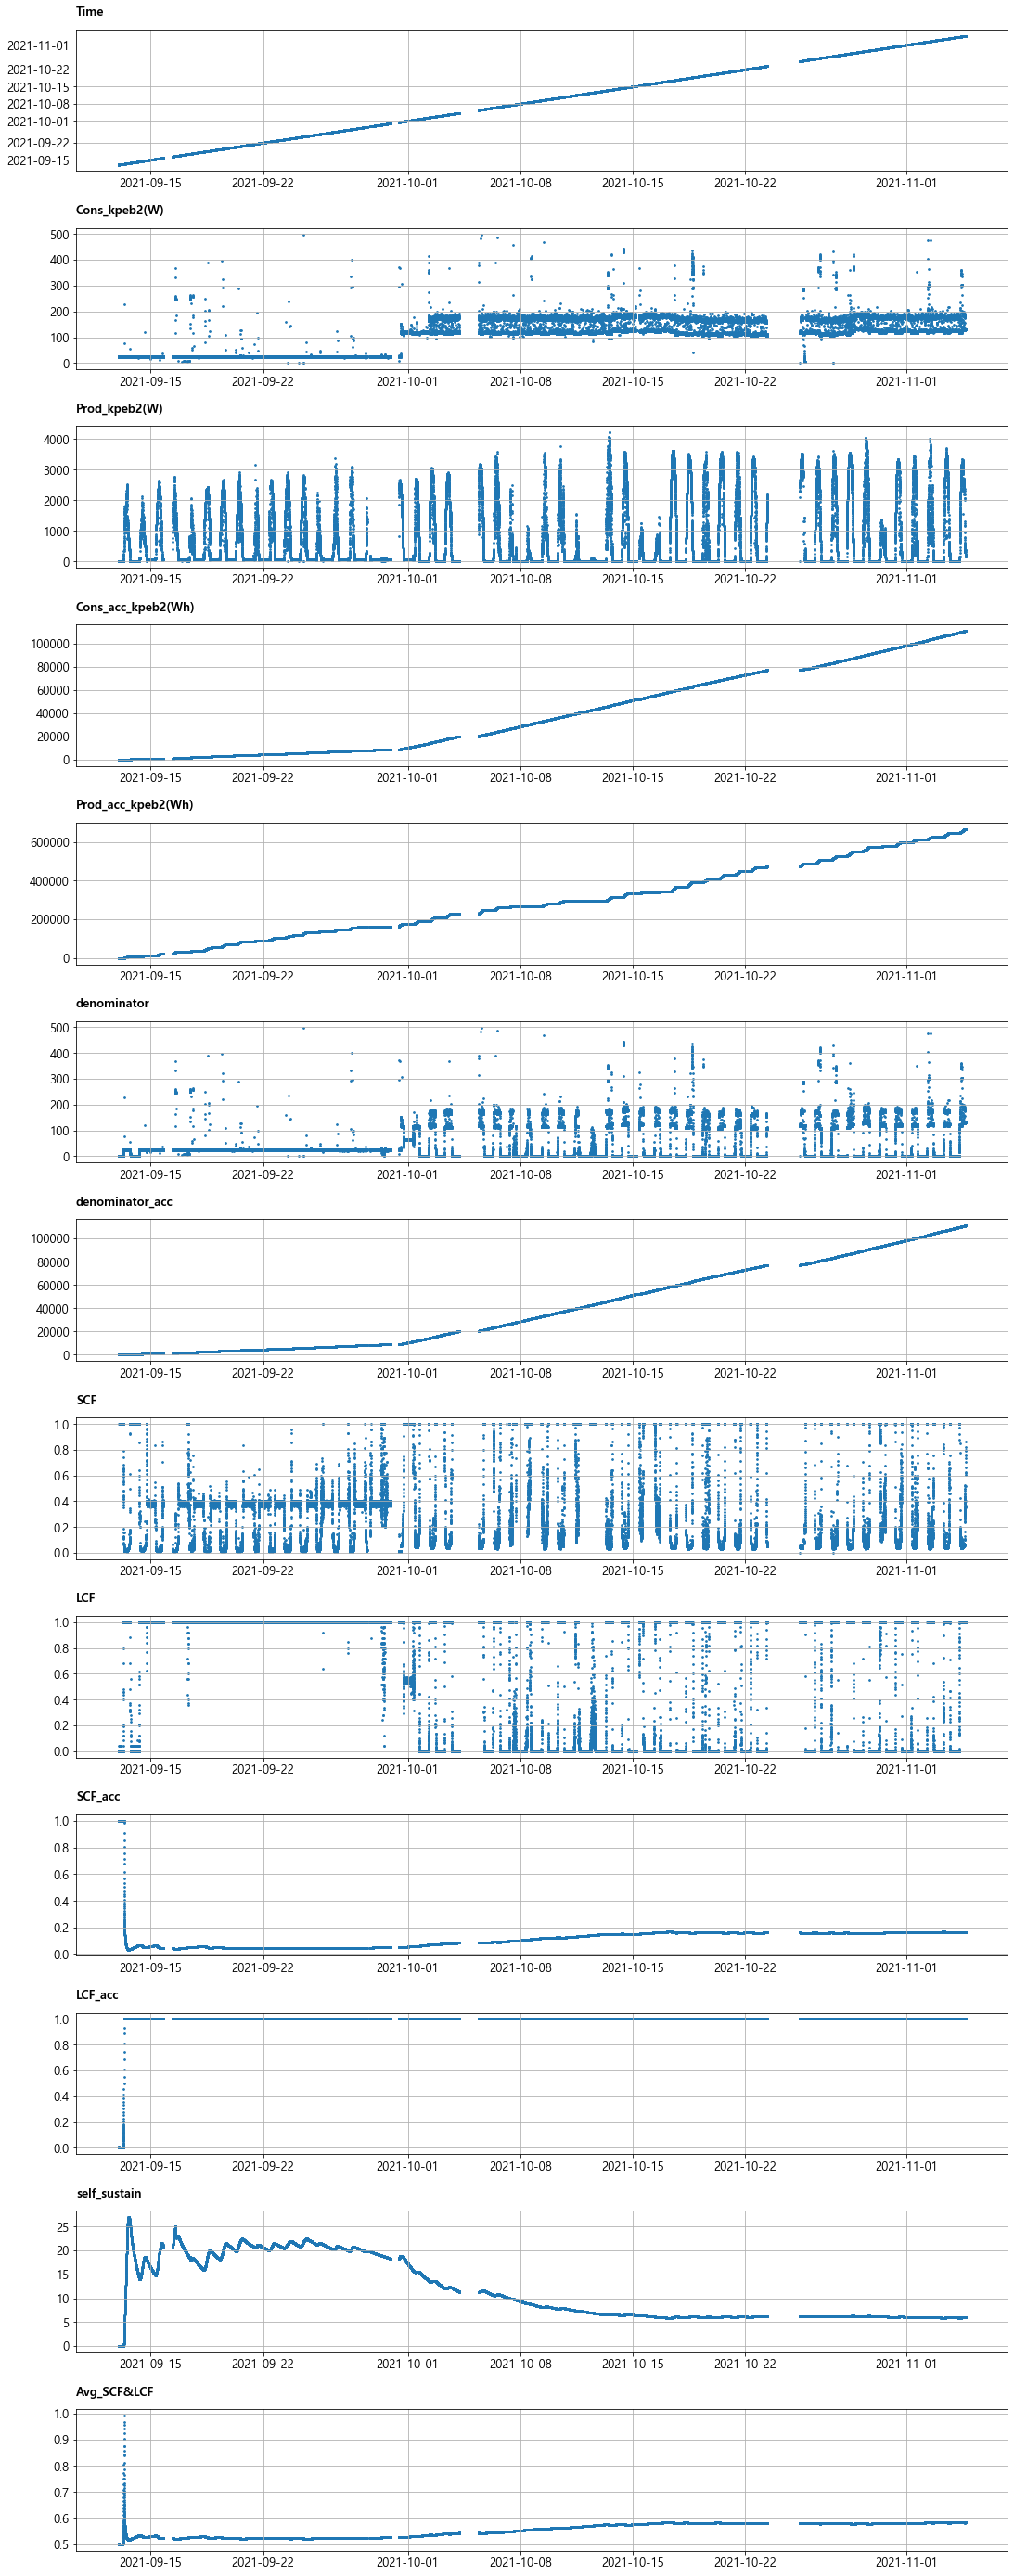

In [17]:
fig, ax = plt.subplots(figsize=(18,50))


for i in range(len(df_kpeb2.columns)):
    plt.subplot(len(df_kpeb2.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.4)
#     plt.xlim(pd.Timestamp('2021-04-01'), pd.Timestamp('2021-11-30'))
    name = df_kpeb2.columns[i]
    plt.scatter(x=df_kpeb2['Time'], y=df_kpeb2[name], s=3)   
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)    
    plt.grid(True)
plt.show()
fig.tight_layout()

# Line plotting

In [18]:
df_kpeb2=df_kpeb2.set_index('Time')

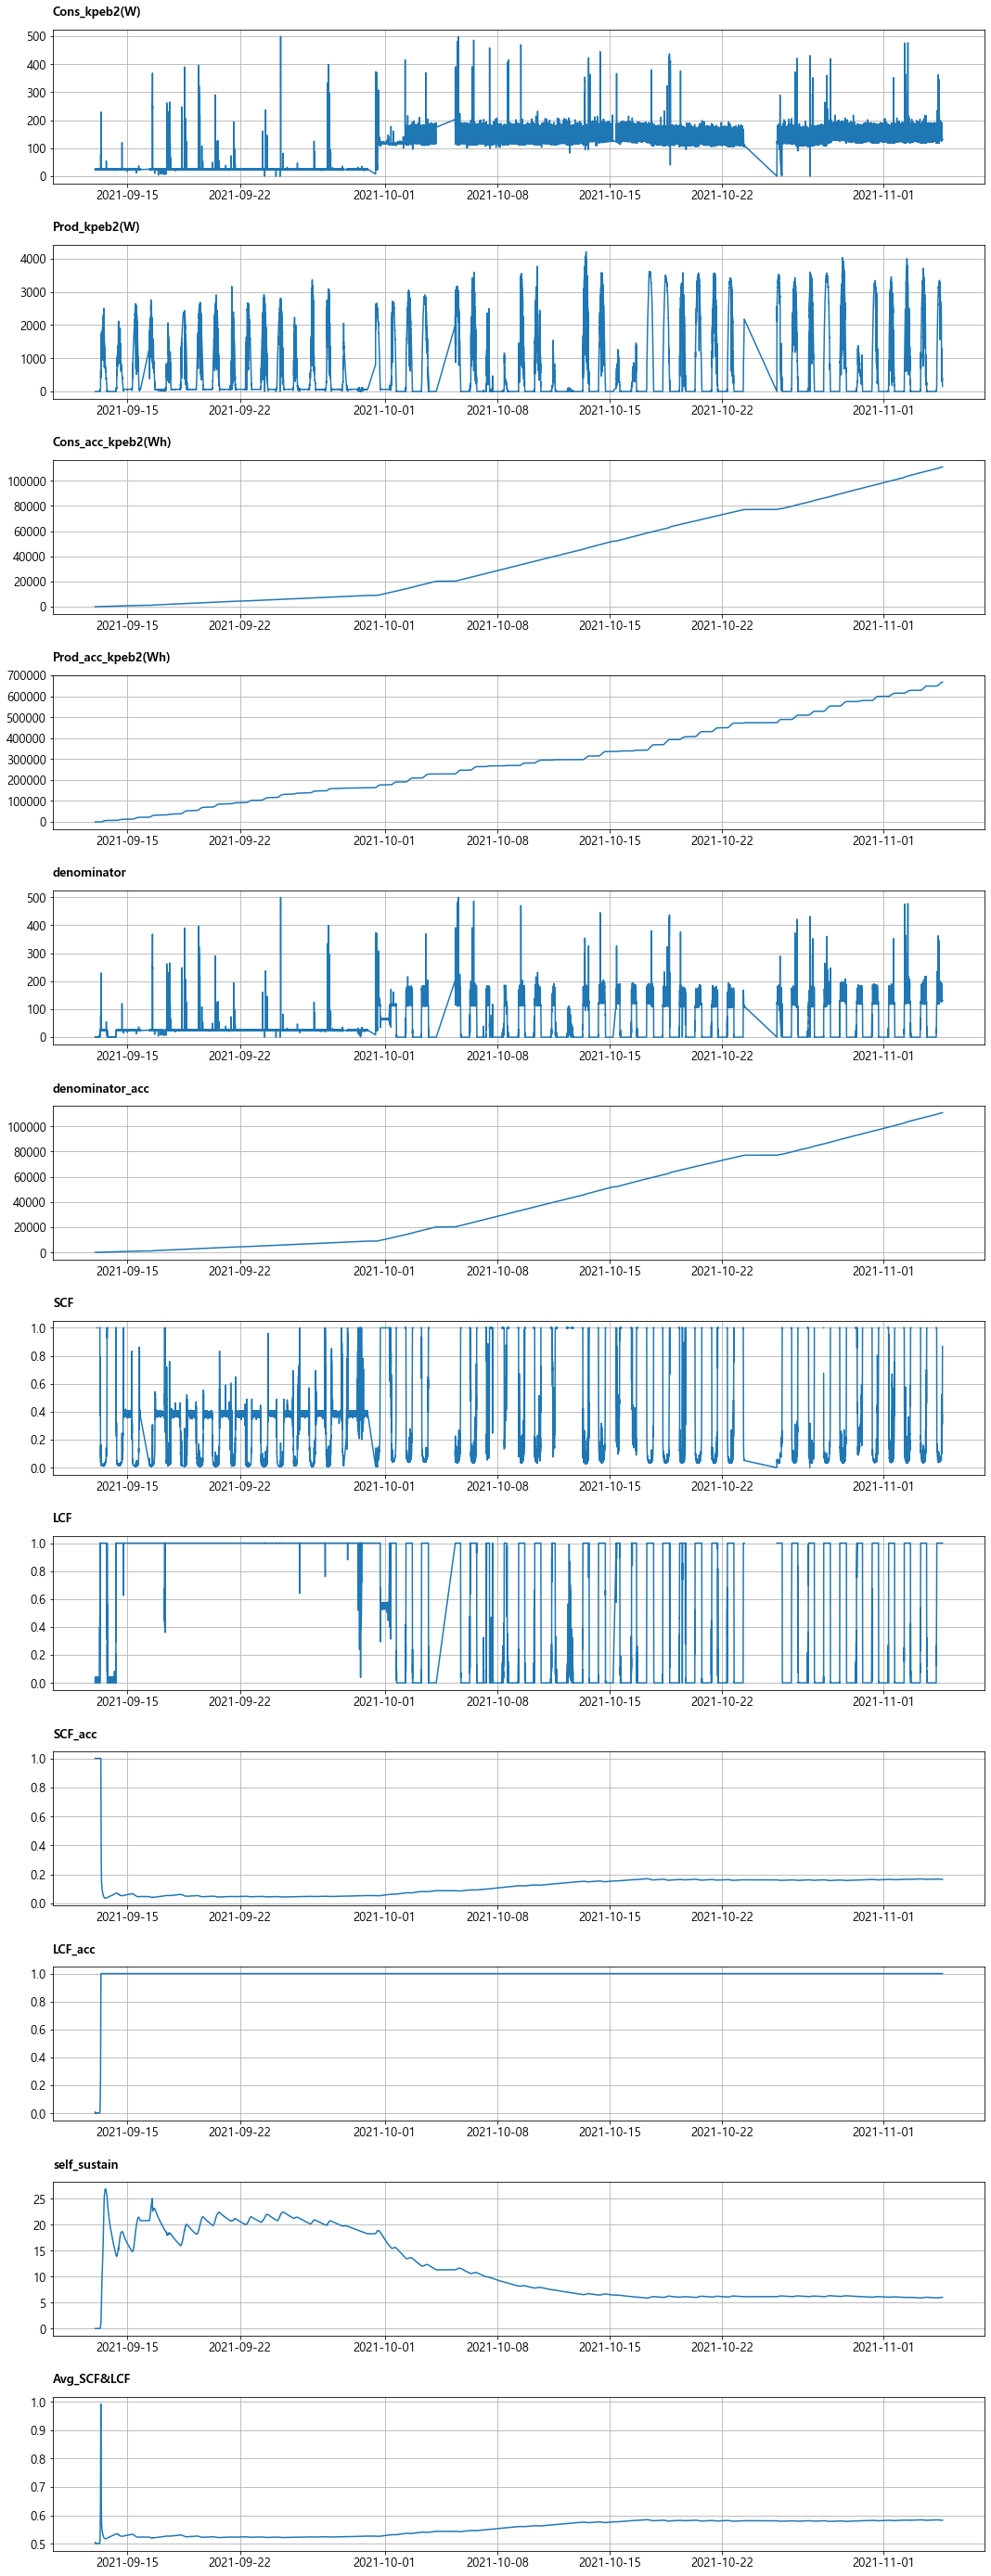

In [19]:
fig, ax = plt.subplots(figsize=(18,50))

for i in range(len(df_kpeb2.columns)):
    plt.subplot(len(df_kpeb2.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.4)
    name = df_kpeb2.columns[i]
    plt.plot(df_kpeb2[name])    
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)                
#     plt.xlim(pd.Timestamp('2020-11-01'), pd.Timestamp('2021-08-31'))    
    plt.grid(True)
plt.show()
fig.tight_layout()